# Model - CIC IoT 2023 Dataset for Cybersecurity Research

[University of New Brunswick - Canadian Institute for Cybersecurity](https://www.unb.ca/cic/datasets/index.html)

TODOs:
- Test first layer as a binary classification (attack/benign)
- Test limiting weights
- Test dropping Protocol feature
- Test adding a feature indicating the highest protocol layer

# Imports

In [1]:
import os
import sys
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from IPython.display import HTML

sys.path.append('../')
n_jobs = 20

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier

## Definitions

In [3]:
import utils
import model_utils
import visualization as viz

from multi_stage_classifier import MultiStageClassifier, ModelStage

constants = utils.get_constants()
seed = constants['seed']

parquet_path = constants['parquet_path']
refined_parquet_path = constants['refined_parquet_path']

features = constants['features']
protocol_layer = constants['protocol_layer']
protocol_layer_map = constants['protocol_layer_map']
attack_category = constants['attack_category']
attack_category_map = constants['attack_category_map']

## Read datasets

In [4]:
df = pd.read_parquet(parquet_path)
df_refined = pd.read_parquet(refined_parquet_path)

features_list = utils.get_features_list(df)
refined_features_list = utils.get_features_list(df_refined)

# features_list.remove('Protocol Type')
# refined_features_list.remove('Protocol Type')

# Baseline

## Binary Classification - Attack / Benign flow

In [5]:
%%time

is_attack = (df.general_label != 'Benign').map({
    True: 'Attack',
    False: 'Benign'
}).astype('category')

baseline_binary_df_split = model_utils.get_train_test_split(
    df,
    target=is_attack,
    sample_size=5_000_000,
    train_frac=0.80
)

Training dataset size: 4.0M (80.0%).
Test dataset size: 1.0M (20.0%).
CPU times: user 20.7 s, sys: 4.07 s, total: 24.8 s
Wall time: 24.7 s


Execution time (Model fit): 0:01:43.271715
Execution time (Predict): 0:00:04.209240
              precision    recall  f1-score   support

      Attack      0.999     0.998     0.999    976502
      Benign      0.938     0.960     0.949     23498

    accuracy                          0.998   1000000
   macro avg      0.969     0.979     0.974   1000000
weighted avg      0.998     0.998     0.998   1000000

CPU times: user 23min 5s, sys: 17.8 s, total: 23min 22s
Wall time: 1min 54s


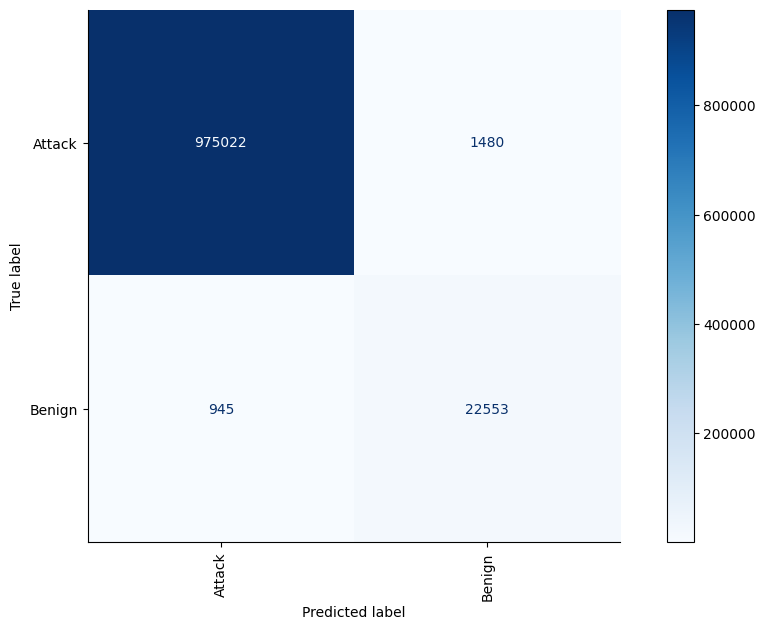

In [7]:
%%time

model_binary_baseline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_jobs=n_jobs, random_state=seed))
])

X_train, X_test, y_train, y_test = baseline_binary_df_split

model_utils.train_model(model_binary_baseline, X_train, y_train)
model_utils.evaluate_model(model_binary_baseline, X_test, y_test)

## 7+1 Classes

In [10]:
%%time

baseline_binary_df_split = model_utils.get_train_test_split(
    df,
    target='general_label',
    sample_size=sample_size,
    train_frac=0.80
)

Training dataset size: 4.0M (80.0%).
Test dataset size: 1.0M (20.0%).
CPU times: user 15.3 s, sys: 2.91 s, total: 18.3 s
Wall time: 18.2 s


Execution time (Model fit): 0:02:12.270721
Execution time (Predict): 0:00:05.864994
              precision    recall  f1-score   support

      Benign      0.912     0.977     0.943     23399
  BruteForce      0.991     0.389     0.559       280
        DDoS      1.000     1.000     1.000    727749
         DoS      1.000     1.000     1.000    173214
       Mirai      1.000     1.000     1.000     56733
       Recon      0.901     0.816     0.856      7686
    Spoofing      0.895     0.858     0.876     10384
         Web      0.976     0.292     0.449       555

    accuracy                          0.996   1000000
   macro avg      0.959     0.791     0.835   1000000
weighted avg      0.996     0.996     0.996   1000000

CPU times: user 33min 4s, sys: 14.6 s, total: 33min 18s
Wall time: 2min 24s


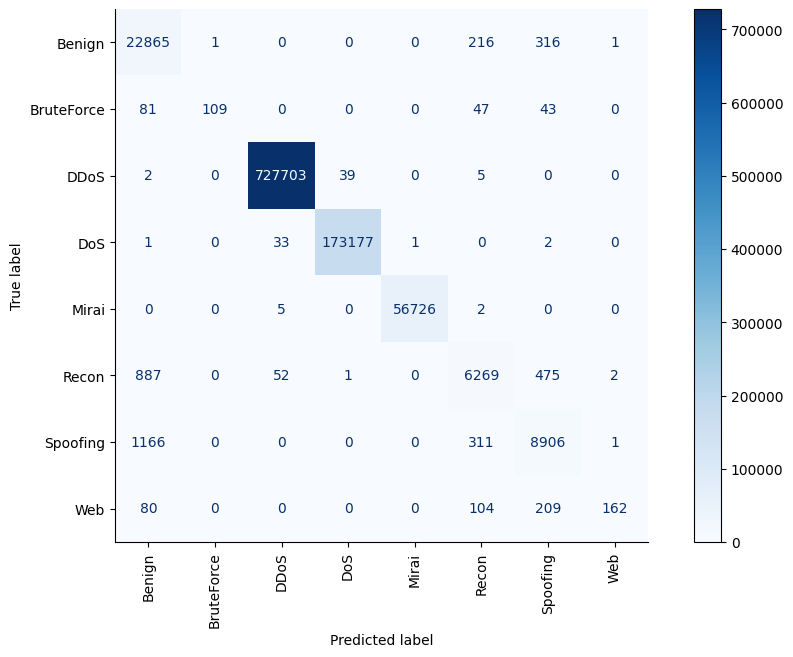

In [11]:
%%time

model_attack_class_baseline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_jobs=n_jobs, random_state=seed))
])

X_train, X_test, y_train, y_test = baseline_binary_df_split

model_utils.train_model(model_attack_class_baseline, X_train, y_train)
model_utils.evaluate_model(model_attack_class_baseline, X_test, y_test)

# Model (2 Stage)

In [12]:
first_layer = {'DDoS', 'DoS', 'Mirai'}
second_layer = {'Spoofing', 'Recon', 'Web', 'BruteForce'}

## First Stage - DDoS / DoS / Mirai

Here we focus on recall... **TODO: Explain why**

In [13]:
%%time

first_stage_labels = df_refined.general_label.where(df_refined.general_label.isin(first_layer), 'Benign').astype('category').cat.remove_unused_categories()

first_stage_df_split = model_utils.get_train_test_split(
    df_refined,
    target=first_stage_labels,
    sample_size=5_000_000,
    train_frac=0.80
)

Training dataset size: 4.0M (80.0%).
Test dataset size: 1.0M (20.0%).
CPU times: user 17.1 s, sys: 4.45 s, total: 21.6 s
Wall time: 21.6 s


Execution time (Model fit): 0:02:26.550823
Execution time (Predict): 0:00:01.547171
              precision    recall  f1-score   support

      Benign      1.000     0.999     1.000     42438
        DDoS      1.000     1.000     1.000    728220
         DoS      1.000     1.000     1.000    172974
       Mirai      1.000     1.000     1.000     56368

    accuracy                          1.000   1000000
   macro avg      1.000     1.000     1.000   1000000
weighted avg      1.000     1.000     1.000   1000000

CPU times: user 41min 38s, sys: 6.75 s, total: 41min 44s
Wall time: 2min 33s


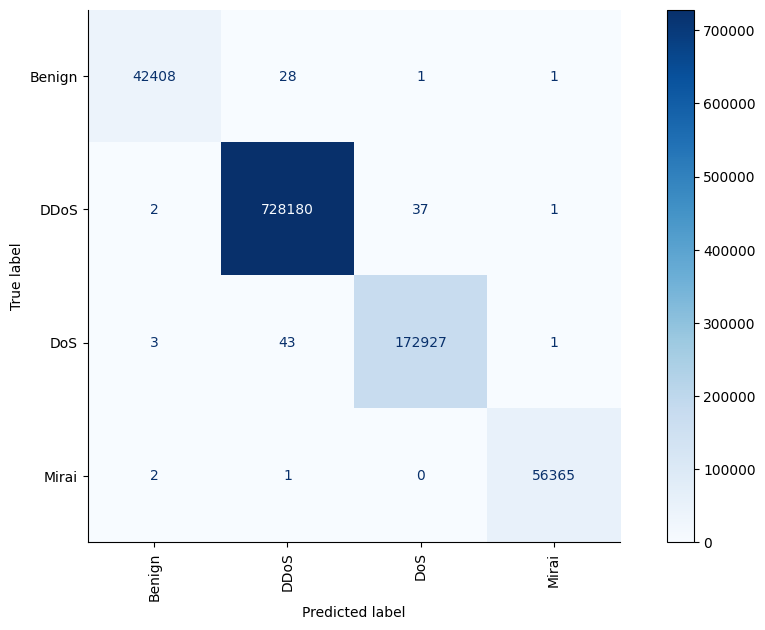

In [14]:
%%time

first_stage_model = Pipeline([
    ('model', RandomForestClassifier(
        max_features=9,
        class_weight='balanced',
        n_jobs=n_jobs,
        random_state=seed
    ))
])

X_train, X_test, y_train, y_test = first_stage_df_split

model_utils.train_model(first_stage_model, X_train, y_train)
model_utils.evaluate_model(first_stage_model, X_test, y_test)

## Second Layer - Spoofing / Recon / Web / Brute Force

In [15]:
%%time

df_second_layer = df_refined[~df_refined.general_label.isin(first_layer)]
second_layer_target = (
    df_second_layer.general_label
    .where(df_second_layer.general_label.isin(second_layer), 'Benign')
    .astype('category')
    .cat.remove_unused_categories()
)

second_stage_df_split = model_utils.get_train_test_split(
    df_second_layer,
    target=second_layer_target,
    train_frac=0.80
)

Training dataset size: 1.6M (80.0%).
Test dataset size: 395.4k (20.0%).
CPU times: user 2.4 s, sys: 304 ms, total: 2.7 s
Wall time: 2.7 s


Execution time (Model fit): 0:02:44.531435
Execution time (Predict): 0:00:01.856911
              precision    recall  f1-score   support

      Benign      0.933     0.981     0.956    219566
  BruteForce      0.993     0.616     0.760      2616
       Recon      0.915     0.867     0.890     70611
    Spoofing      0.931     0.888     0.909     97793
         Web      0.978     0.576     0.725      4846

    accuracy                          0.930    395432
   macro avg      0.950     0.786     0.848    395432
weighted avg      0.930     0.930     0.930    395432

CPU times: user 50min 58s, sys: 2.87 s, total: 51min 1s
Wall time: 2min 48s


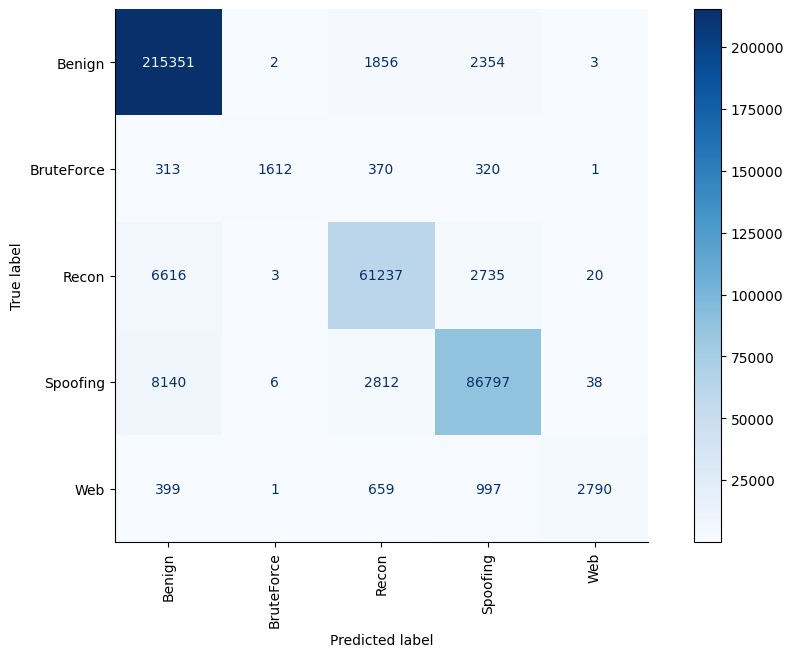

In [16]:
%%time

second_stage_model = Pipeline([
    ('model', RandomForestClassifier(
        max_features=10,
        n_jobs=n_jobs,
        random_state=seed
    ))
])

X_train, X_test, y_train, y_test = second_stage_df_split

model_utils.train_model(second_stage_model, X_train, y_train)
model_utils.evaluate_model(second_stage_model, X_test, y_test)

Execution time (Model fit): 0:02:59.130131
Execution time (Predict): 0:00:01.497449
              precision    recall  f1-score   support

      Benign      0.932     0.982     0.956    219566
  BruteForce      0.985     0.623     0.763      2616
       Recon      0.918     0.867     0.892     70611
    Spoofing      0.933     0.887     0.909     97793
         Web      0.968     0.583     0.727      4846

    accuracy                          0.931    395432
   macro avg      0.947     0.788     0.850    395432
weighted avg      0.931     0.931     0.931    395432

CPU times: user 53min 28s, sys: 2.77 s, total: 53min 31s
Wall time: 3min 2s


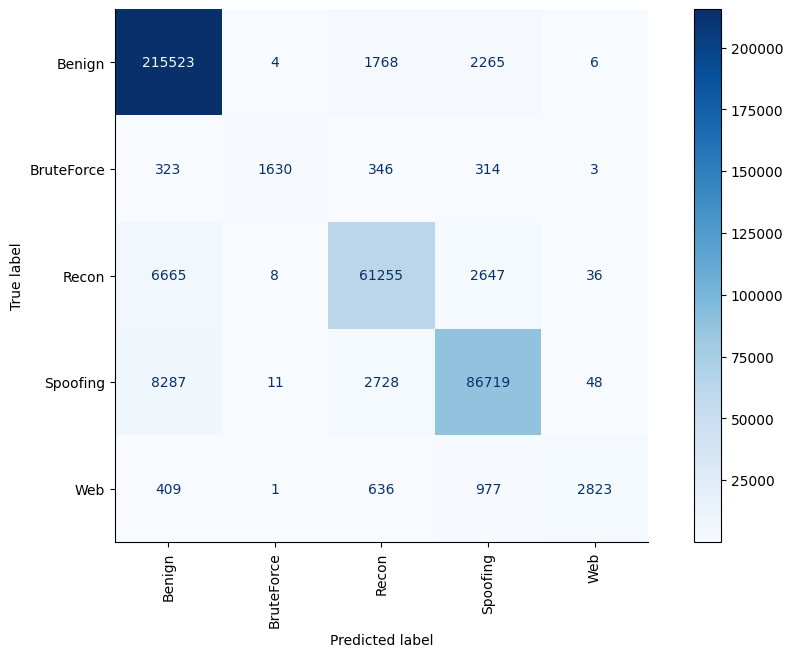

In [17]:
%%time

second_stage_model = Pipeline([
    ('model', RandomForestClassifier(
        max_features=10,
        criterion='entropy',
        n_jobs=n_jobs,
        random_state=seed
    ))
])

X_train, X_test, y_train, y_test = second_stage_df_split

model_utils.train_model(second_stage_model, X_train, y_train)
model_utils.evaluate_model(second_stage_model, X_test, y_test)

# Multi-Stage Model

In [18]:
%%time

multi_stage_df_split = model_utils.get_train_test_split(
    df_refined,
    target='general_label',
    sample_size=10_000_000,
    train_frac=0.80
)

Training dataset size: 8.0M (80.0%).
Test dataset size: 2.0M (20.0%).
CPU times: user 21.5 s, sys: 4.35 s, total: 25.8 s
Wall time: 25.8 s


Execution time (Model fit): 0:06:22.044240
Execution time (Predict): 0:00:04.091833
              precision    recall  f1-score   support

      Benign      0.925     0.979     0.952     47297
  BruteForce      0.987     0.545     0.702       547
        DDoS      1.000     1.000     1.000   1455519
         DoS      1.000     1.000     1.000    347087
       Mirai      1.000     1.000     1.000    112615
       Recon      0.907     0.851     0.878     15196
    Spoofing      0.924     0.872     0.897     20666
         Web      0.975     0.575     0.723      1073

    accuracy                          0.997   2000000
   macro avg      0.965     0.853     0.894   2000000
weighted avg      0.997     0.997     0.997   2000000

CPU times: user 1h 46min 16s, sys: 51.5 s, total: 1h 47min 8s
Wall time: 6min 38s


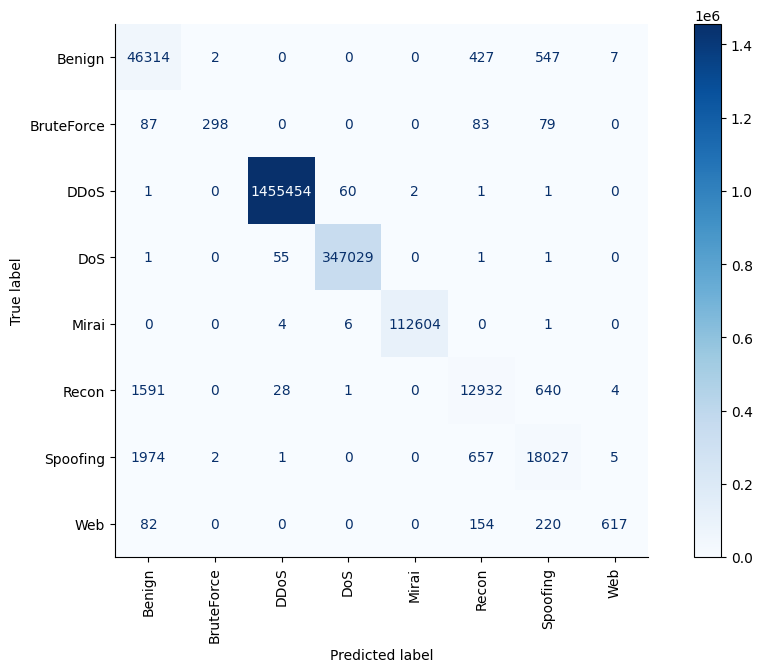

In [19]:
%%time
multi_stage_model = MultiStageClassifier(
    stages=[
        ModelStage(
            model=RandomForestClassifier(max_features=10, class_weight='balanced', n_jobs=n_jobs, random_state=seed),
            labels={'DDoS', 'DoS', 'Mirai'}
        ),
        ModelStage(
            model=RandomForestClassifier(max_features=10, n_jobs=n_jobs, random_state=seed),
            labels={'Spoofing', 'Recon', 'Web', 'BruteForce', 'Benign'}
        ),
    ],
)


X_train, X_test, y_train, y_test = multi_stage_df_split

model_utils.train_model(multi_stage_model, X_train, y_train)
model_utils.evaluate_model(multi_stage_model, X_test, y_test)